In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.ind_optimized_search import IndependentOptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
input_shape = (32, 32, 3)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/cifar_keras/cifar_seq_large_w.h5'
name = 'cifar_seq_large'
total_acc_drop = 0.003

from test_models.cifar_keras import data
_, test_data = data.get_data()

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Weights

In [3]:
layer_names = []

for layer in model_obj.model.layers:
    if layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        layer_names.append(layer.name)

In [7]:
# weights
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
w_scores, opt_params_weights, acc_drop_w = opts.run('weights', start_bw = 8)
opt_params_weights

{'conv2d_1': [8, 9], 'conv2d_2': [8, 9], 'conv2d_3': [8, 9], 'conv2d_4': [8, 9], 'conv2d_5': [8, 9], 'conv2d_6': [8, 9], 'conv2d_7': [8, 9], 'conv2d_8': [8, 9], 'conv2d_9': [8, 9], 'conv2d_10': [8, 9], 'conv2d_11': [8, 9], 'conv2d_12': [8, 9], 'conv2d_13': [8, 9], 'conv2d_14': [8, 9], 'dense_1': [8, 7]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (8, 9) Local opt: (9, 10) Performance diff: 0.000728
Chosen:  (8, 9)
After quantizing layer conv2d_1 | Measured accuracy drop 0.001334 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (5, 6) Local opt: (5, 7) Performance diff: 0.001698
Chosen:  (5, 7)
After quantizing layer conv2d_2 | Measured accuracy drop 0.001577 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (5, 6) Local opt: (6, 7) Performance diff: 0.001092
Chosen:  (5, 6)
After quantizing layer conv2d_3 | Measured accuracy drop 0.001941 | Acceptable accuracy drop: 0.003000
Q

{'conv2d_1': (8, 9),
 'conv2d_2': (5, 7),
 'conv2d_3': (5, 6),
 'conv2d_4': (6, 7),
 'conv2d_5': (5, 6),
 'conv2d_6': (5, 6),
 'conv2d_7': (4, 6),
 'conv2d_8': (4, 6),
 'conv2d_9': (4, 6),
 'conv2d_10': (3, 5),
 'conv2d_11': (4, 6),
 'conv2d_12': (3, 5),
 'conv2d_13': (2, 4),
 'conv2d_14': (2, 4),
 'dense_1': (4, 5)}

Floating point model accuracy: 82.430 %
Quantized model accuracy: 81.500 %
Accuracy drop of 1.128 %


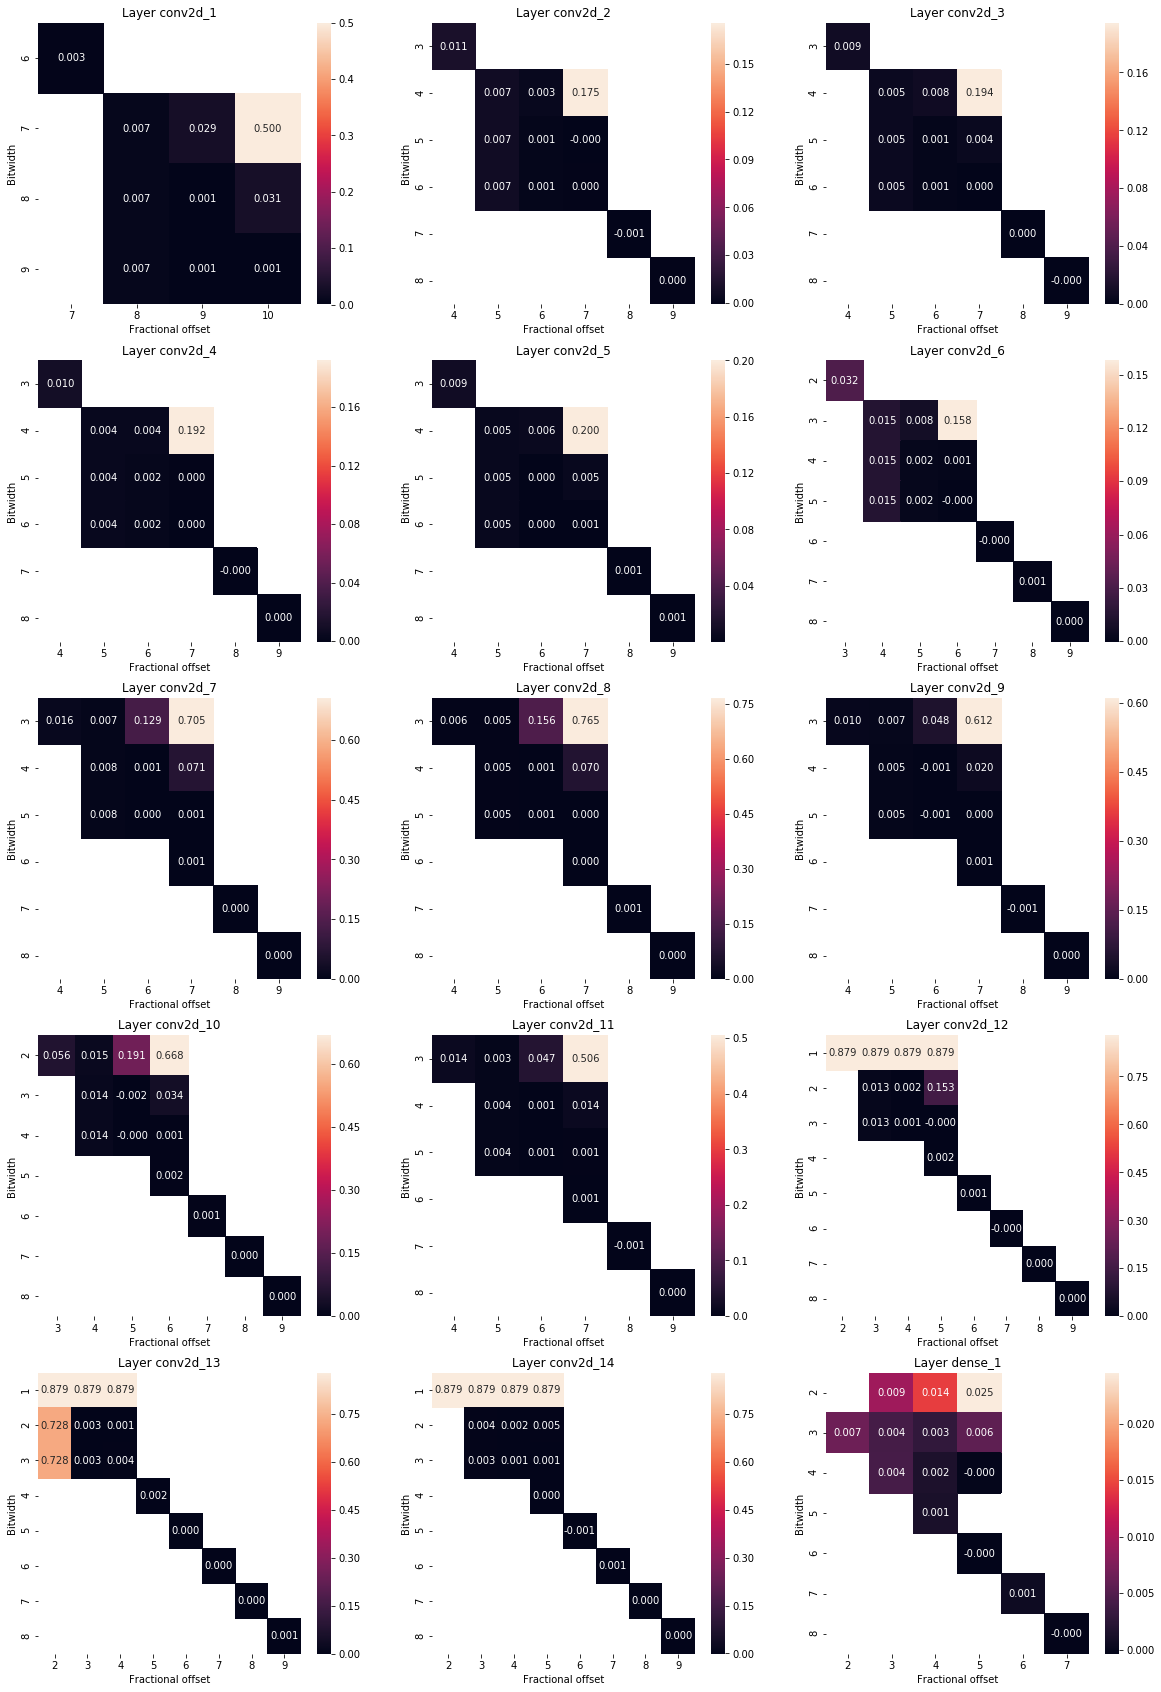

In [9]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [10]:
for layer in w_scores:
    print(f'Layer {layer} acc drop: {w_scores[layer][opt_params_weights[layer][0]][opt_params_weights[layer][1]]:.5f}')

Layer conv2d_1 acc drop: 0.00133
Layer conv2d_2 acc drop: -0.00036
Layer conv2d_3 acc drop: 0.00146
Layer conv2d_4 acc drop: 0.00036
Layer conv2d_5 acc drop: 0.00036
Layer conv2d_6 acc drop: -0.00024
Layer conv2d_7 acc drop: 0.00121
Layer conv2d_8 acc drop: 0.00146
Layer conv2d_9 acc drop: -0.00061
Layer conv2d_10 acc drop: -0.00182
Layer conv2d_11 acc drop: 0.00097
Layer conv2d_12 acc drop: -0.00036
Layer conv2d_13 acc drop: 0.00097
Layer conv2d_14 acc drop: 0.00170
Layer dense_1 acc drop: -0.00012


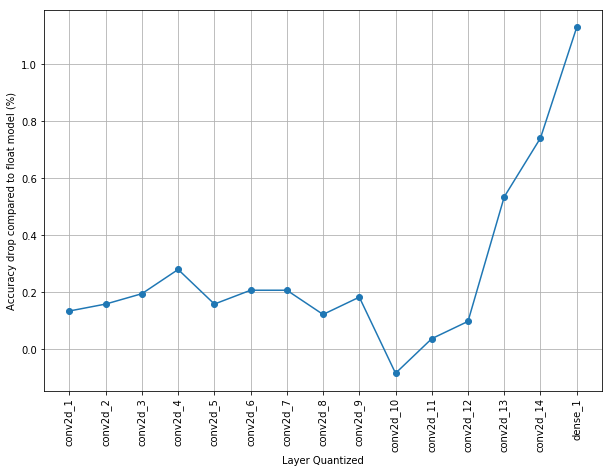

In [11]:
x = np.arange(1, len(acc_drop_w.values()) + 1, 1)
y = np.array(list(acc_drop_w.values())) * 100
labels = list(acc_drop_w.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

In [12]:
import pickle

save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras CIFAR10/'

with open(save_path + 'scores_w.p', 'wb') as f:
    pickle.dump(w_scores, f)
with open(save_path + 'opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f)
with open(save_path + 'acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f)

## Biases

In [5]:
# biases
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
b_scores, opt_params_biases, acc_drop_b = opts.run('biases', start_bw = 8)
opt_params_biases

{'conv2d_1': [8, 10], 'conv2d_2': [8, 10], 'conv2d_3': [8, 10], 'conv2d_4': [8, 9], 'conv2d_5': [8, 9], 'conv2d_6': [8, 9], 'conv2d_7': [8, 10], 'conv2d_8': [8, 10], 'conv2d_9': [8, 9], 'conv2d_10': [8, 10], 'conv2d_11': [8, 9], 'conv2d_12': [8, 9], 'conv2d_13': [8, 9], 'conv2d_14': [8, 10], 'dense_1': [8, 9]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (5, 7) Local opt: (6, 8) Performance diff: 0.001820
Chosen:  (6, 8)
After quantizing layer conv2d_1 | Measured accuracy drop 0.001092 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (1, 3) Local opt: (2, 3) Performance diff: 0.000849
Chosen:  (1, 3)
After quantizing layer conv2d_2 | Measured accuracy drop 0.000485 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (2, 4) Local opt: (2, 3) Performance diff: 0.000000
Chosen:  (2, 3)
After quantizing layer conv2d_3 | Measured accuracy drop 0.001092 | Acceptable accuracy drop: 0.00

{'conv2d_1': (6, 8),
 'conv2d_2': (1, 3),
 'conv2d_3': (2, 3),
 'conv2d_4': (2, 4),
 'conv2d_5': (1, 2),
 'conv2d_6': (1, 1),
 'conv2d_7': (1, 2),
 'conv2d_8': (1, 2),
 'conv2d_9': (1, 2),
 'conv2d_10': (1, 2),
 'conv2d_11': (1, 2),
 'conv2d_12': (2, 3),
 'conv2d_13': (1, 2),
 'conv2d_14': (1, 3),
 'dense_1': (1, 2)}

Floating point model accuracy: 82.430 %
Quantized model accuracy: 82.060 %
Accuracy drop of 0.449 %


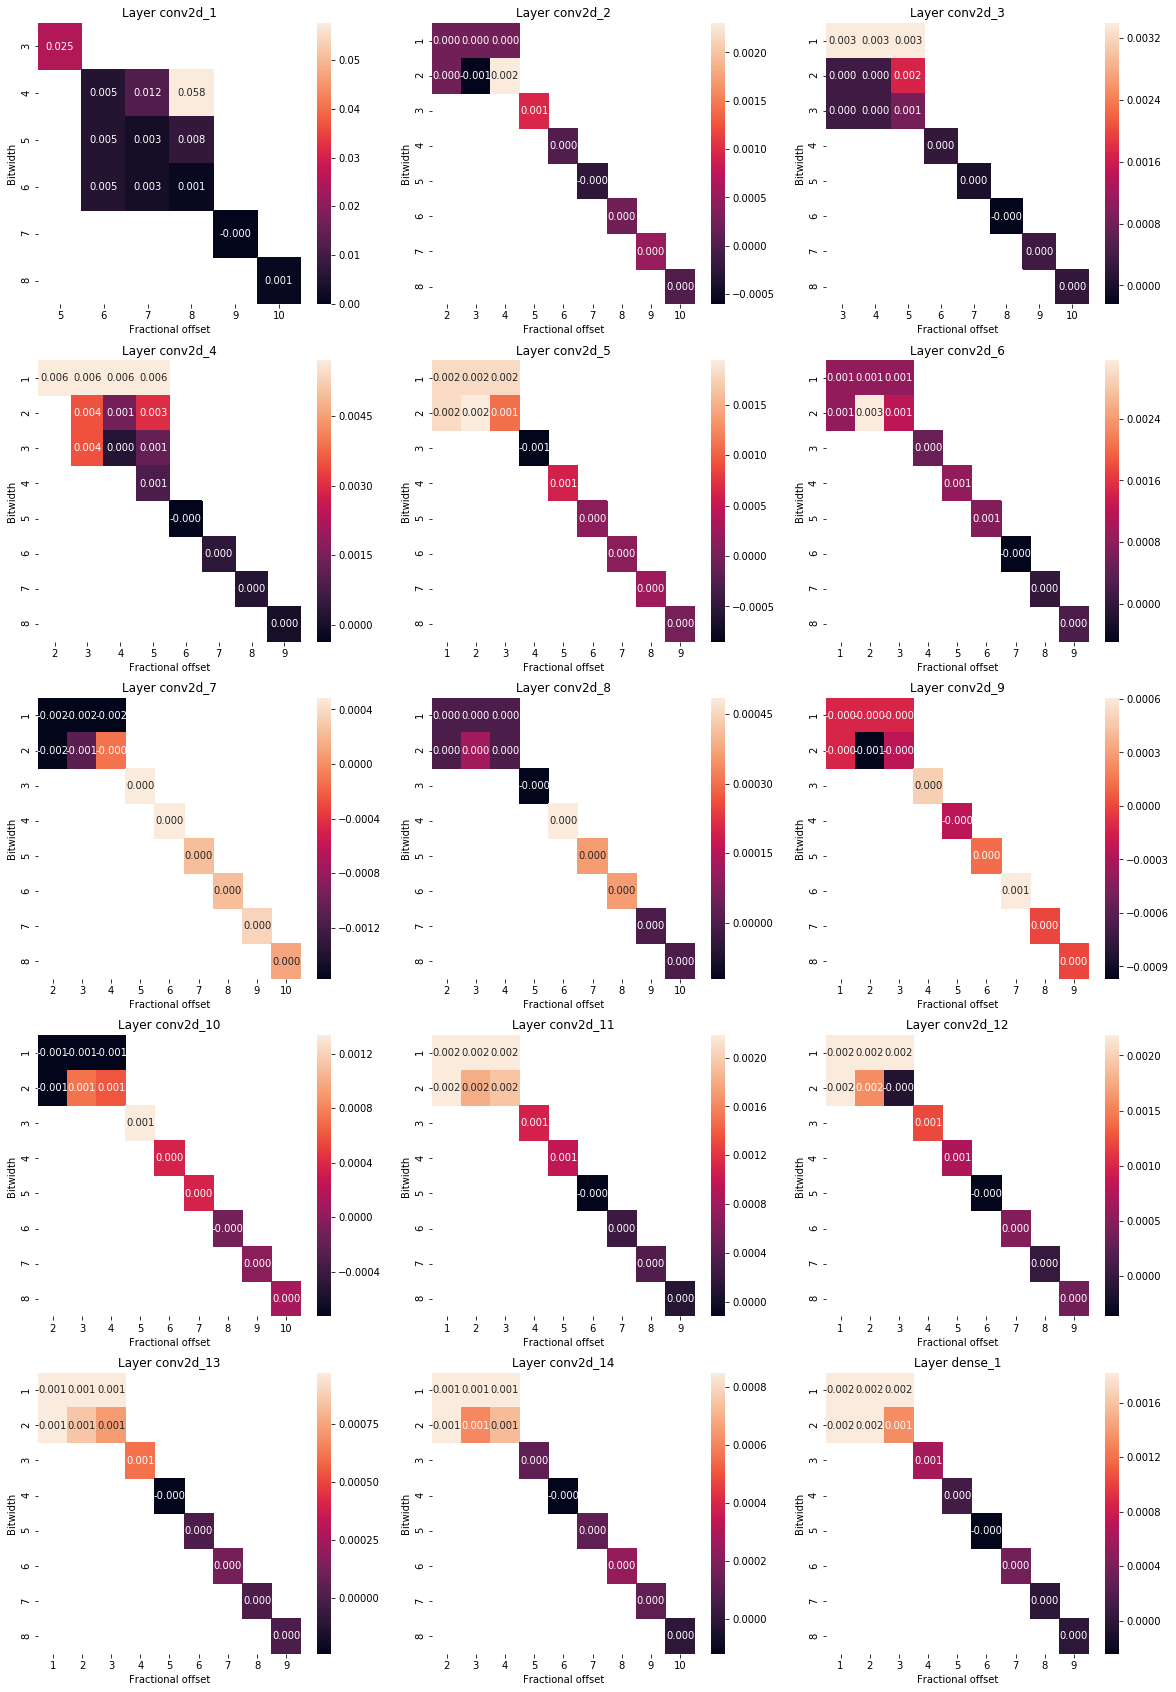

In [6]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_biases_quantization(model_obj, opt_params_biases)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [7]:
for layer in b_scores:
    print(f'Layer {layer} acc drop: {b_scores[layer][opt_params_biases[layer][0]][opt_params_biases[layer][1]]:.5f}')

Layer conv2d_1 acc drop: 0.00109
Layer conv2d_2 acc drop: 0.00024
Layer conv2d_3 acc drop: 0.00036
Layer conv2d_4 acc drop: 0.00146
Layer conv2d_5 acc drop: 0.00182
Layer conv2d_6 acc drop: 0.00085
Layer conv2d_7 acc drop: -0.00158
Layer conv2d_8 acc drop: 0.00000
Layer conv2d_9 acc drop: -0.00012
Layer conv2d_10 acc drop: -0.00073
Layer conv2d_11 acc drop: 0.00218
Layer conv2d_12 acc drop: -0.00012
Layer conv2d_13 acc drop: 0.00097
Layer conv2d_14 acc drop: 0.00085
Layer dense_1 acc drop: 0.00182


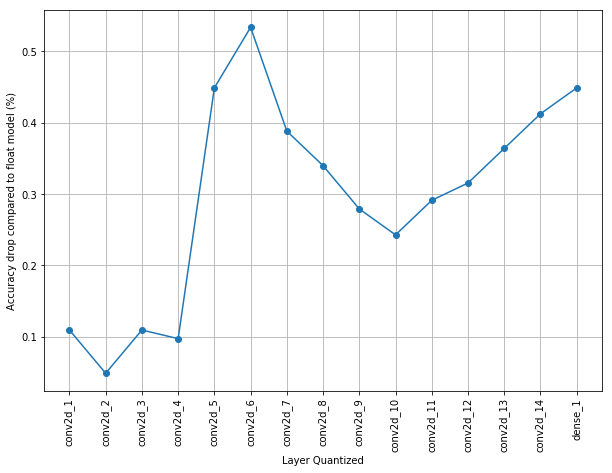

In [8]:
x = np.arange(1, len(acc_drop_b.values()) + 1, 1)
y = np.array(list(acc_drop_b.values())) * 100
labels = list(acc_drop_b.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

In [10]:
# activations
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
a_scores, opt_params_act, acc_drop_a = opts.run('activations', start_bw = 8)
opt_params_act

{'conv2d_1': [8, 7], 'conv2d_2': [8, 4], 'conv2d_3': [8, 3], 'conv2d_4': [8, 3], 'conv2d_5': [8, 2], 'conv2d_6': [8, 3], 'conv2d_7': [8, 3], 'conv2d_8': [8, 3], 'conv2d_9': [8, 2], 'conv2d_10': [8, 3], 'conv2d_11': [8, 3], 'conv2d_12': [8, 2], 'conv2d_13': [8, 2], 'conv2d_14': [8, 2], 'dense_1': [8, 2]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (7, 7) Local opt: (8, 8) Performance diff: 0.001698
Chosen:  (8, 8)
After quantizing layer conv2d_1 | Measured accuracy drop -0.000364 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (6, 3) Local opt: (6, 3) Performance diff: 0.000000
Chosen:  (6, 3)
After quantizing layer conv2d_2 | Measured accuracy drop 0.001456 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (6, 2) Local opt: (7, 3) Performance diff: 0.001334
Chosen:  (6, 2)
After quantizing layer conv2d_3 | Measured accuracy drop 0.002426 | Acceptable accuracy drop: 0.003000
Q

{'conv2d_1': (8, 8),
 'conv2d_2': (6, 3),
 'conv2d_3': (6, 2),
 'conv2d_4': (4, 0),
 'conv2d_5': (6, 1),
 'conv2d_6': (5, 1),
 'conv2d_7': (5, 2),
 'conv2d_8': (5, 1),
 'conv2d_9': (4, 0),
 'conv2d_10': (5, 1),
 'conv2d_11': (4, 1),
 'conv2d_12': (3, 0),
 'conv2d_13': (4, 0),
 'conv2d_14': (4, 0),
 'dense_1': (4, 0)}

Floating point model accuracy: 82.430 %
Quantized model accuracy: 81.440 %
Accuracy drop of 1.201 %


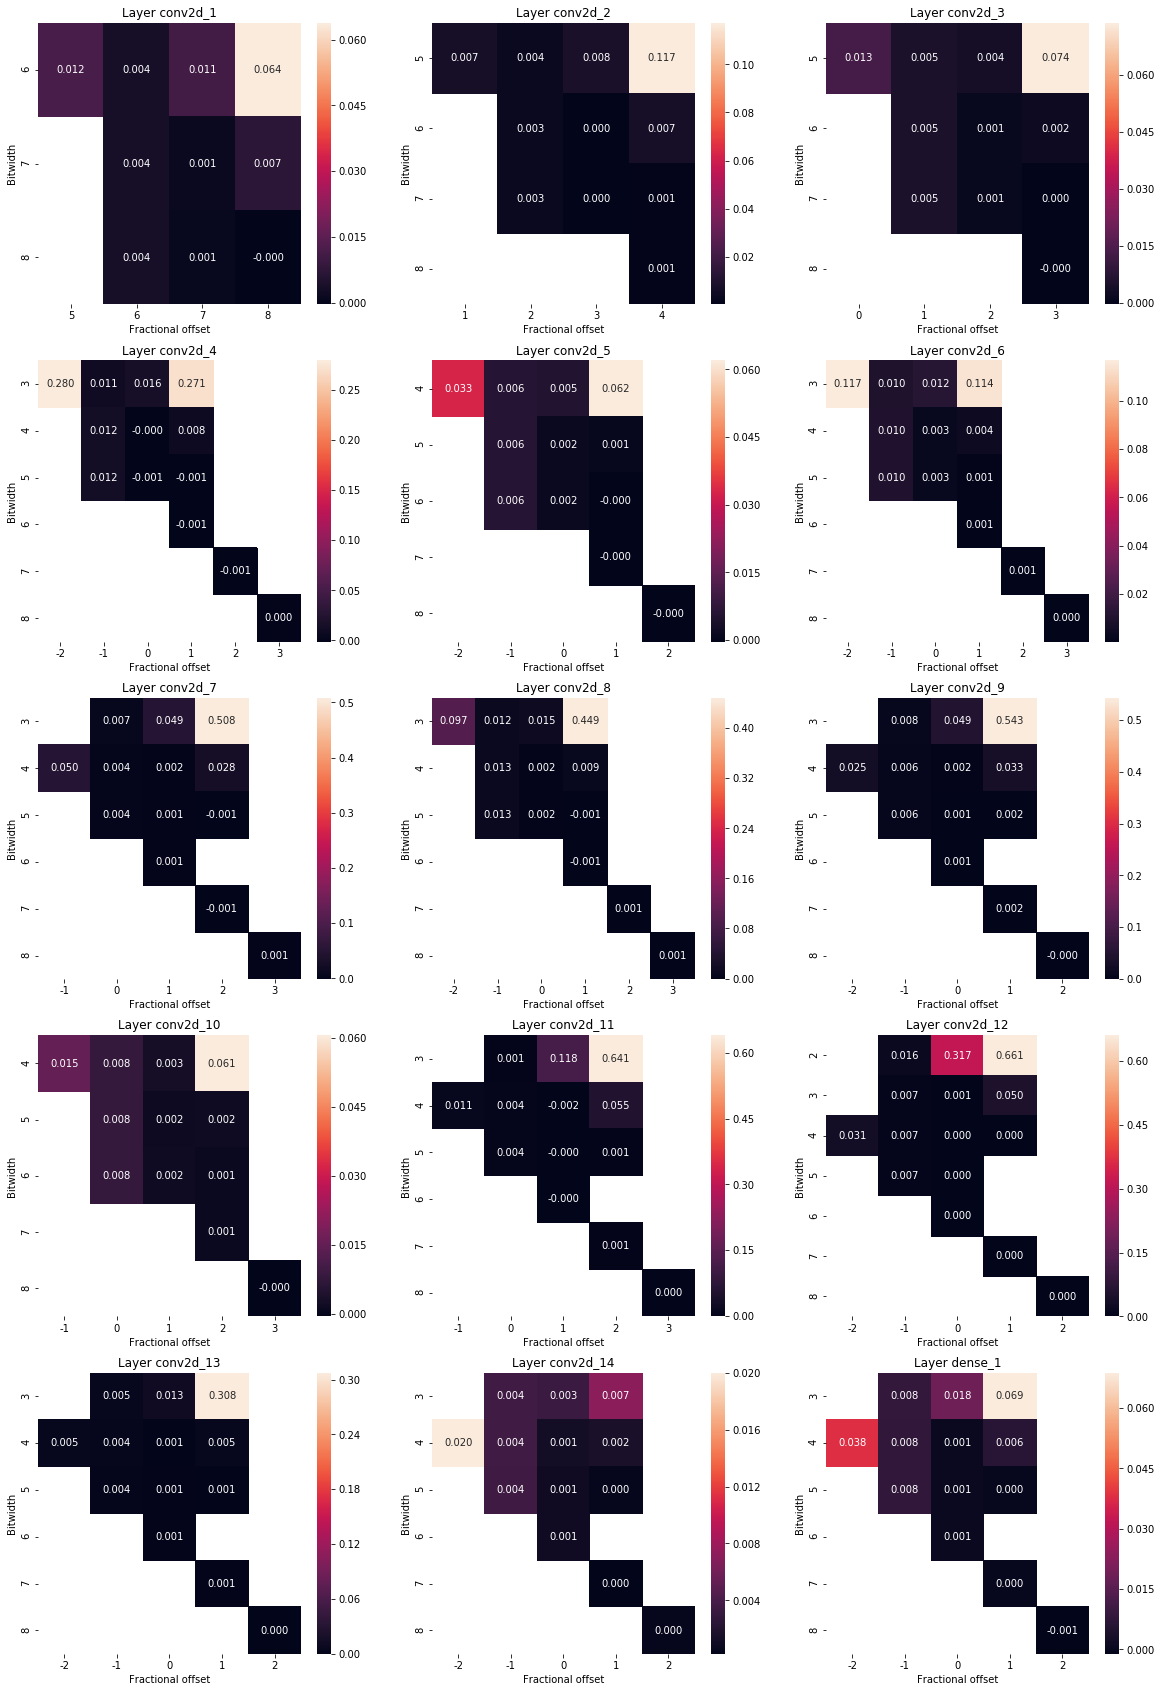

In [11]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act))
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [12]:
for layer in a_scores:
    print(f'Layer {layer} acc drop: {a_scores[layer][opt_params_act[layer][0]][opt_params_act[layer][1]]:.5f}')

Layer conv2d_1 acc drop: -0.00036
Layer conv2d_2 acc drop: 0.00024
Layer conv2d_3 acc drop: 0.00133
Layer conv2d_4 acc drop: -0.00049
Layer conv2d_5 acc drop: -0.00036
Layer conv2d_6 acc drop: 0.00109
Layer conv2d_7 acc drop: -0.00061
Layer conv2d_8 acc drop: -0.00061
Layer conv2d_9 acc drop: 0.00206
Layer conv2d_10 acc drop: 0.00158
Layer conv2d_11 acc drop: -0.00182
Layer conv2d_12 acc drop: 0.00146
Layer conv2d_13 acc drop: 0.00109
Layer conv2d_14 acc drop: 0.00121
Layer dense_1 acc drop: 0.00073


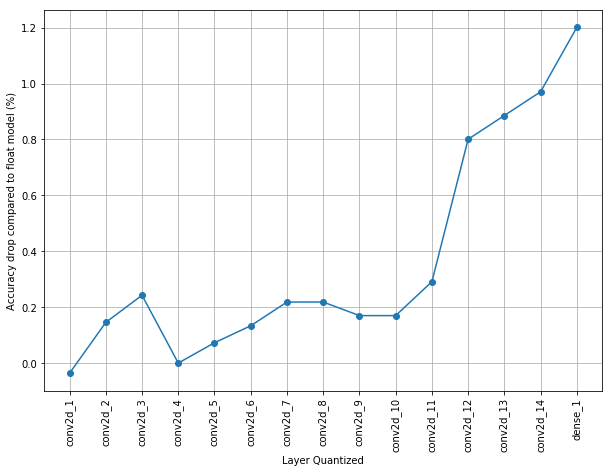

In [13]:
x = np.arange(1, len(acc_drop_a.values()) + 1, 1)
y = np.array(list(acc_drop_a.values())) * 100
labels = list(acc_drop_a.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

In [17]:
with open(save_path + 'opt_params_w.p', 'rb') as f:
    opt_params_weights = pickle.load(f)

In [18]:
def quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params={}, a_quant_params={}):
    
    if a_quant_params:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_fxp_model(a_quant_params))
    else:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_float_model())
    
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, w_quant_params)
    if b_quant_params:
        model_obj = fxp_quantize.fix_biases_quantization(model_obj, b_quant_params)
    
    return (float_model_acc - model_obj.evaluate_accuracy()[1]) / float_model_acc

In [31]:
def evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, a_quant_params):
    
    acc_drop_b = {}
    for i in range(1, len(list(b_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(b_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, test_case)
        acc_drop_b[list(test_case.keys())[-1]] = a
        print(acc_drop_b)

    acc_drop_a = {}
    for i in range(1, len(list(a_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(a_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, test_case)
        acc_drop_a[list(test_case.keys())[-1]] = a
        print(acc_drop_a)
        
    return acc_drop_b, acc_drop_a  

In [32]:
acc_drop_b, acc_drop_a = evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, opt_params_weights, 
                                            opt_params_biases,
                                            opt_params_act)

{'conv2d_1': 0.011160985078248193}
{'conv2d_1': 0.011160985078248193, 'conv2d_2': 0.013344656071818523}
{'conv2d_1': 0.011160985078248193, 'conv2d_2': 0.013344656071818523, 'conv2d_3': 0.015164381899793845}
{'conv2d_1': 0.011160985078248193, 'conv2d_2': 0.013344656071818523, 'conv2d_3': 0.015164381899793845, 'conv2d_4': 0.015407012010190518}
{'conv2d_1': 0.011160985078248193, 'conv2d_2': 0.013344656071818523, 'conv2d_3': 0.015164381899793845, 'conv2d_4': 0.015407012010190518, 'conv2d_5': 0.016013587286182202}
{'conv2d_1': 0.011160985078248193, 'conv2d_2': 0.013344656071818523, 'conv2d_3': 0.015164381899793845, 'conv2d_4': 0.015407012010190518, 'conv2d_5': 0.016013587286182202, 'conv2d_6': 0.02110881960451302}
{'conv2d_1': 0.011160985078248193, 'conv2d_2': 0.013344656071818523, 'conv2d_3': 0.015164381899793845, 'conv2d_4': 0.015407012010190518, 'conv2d_5': 0.016013587286182202, 'conv2d_6': 0.02110881960451302, 'conv2d_7': 0.02268591532209153}
{'conv2d_1': 0.011160985078248193, 'conv2d_2

In [37]:
import pickle
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras CIFAR10/'

with open(save_path + 'scores_b.p', 'wb') as f:
    pickle.dump(b_scores, f)
with open(save_path + 'opt_params_b.p', 'wb') as f:
    pickle.dump(opt_params_biases, f)
with open(save_path + 'acc_drop_b.p', 'wb') as f:
    pickle.dump(acc_drop_b, f)

In [36]:
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras CIFAR10/'

with open(save_path + 'scores_a.p', 'wb') as f:
    pickle.dump(a_scores, f)
with open(save_path + 'opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f)
with open(save_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f)